Backbone to plot PETHs of PL neurons around the time of the CS for a single rat.

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os

if os.environ['SHELL'] == '/bin/zsh':  # Laptop/Mac
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
elif os.environ['SHELL'] in ['/bin/sh', '/bin/bash']:  # Linux desktop
    sys.path.append('/data/GitHub/TraceFC/')
    sys.path.append('/data/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces
from neuropy.io.minianio import MinianIO
import session_directory as sd
from neuropy.analyses.trace_fc import load_events_from_csv
from neuropy.core.ca_neurons import CaNeuronReg, PairwiseMap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up everything for plotting

## NRK todo: move this function into trace_fc github repo

In [ ]:
def get_events():
    """Function to grab events of a certain type from a .csv file"""
    pass

In [2]:
def load_trace_events(sesh_dir: str, 
                      session_type: str in ['tone_recall', 'control_tone_recall', 'ctx_recall', 'ctx_habituation', 
                                            'tone_habituation', 'training'], 
                      event_type = ['CS+', 'CS-', 'shock', 'sync_tone', 'video', 'baseline'], 
                      return_df: bool = False):
    """
    Loads events of a certain type from a session located in the specified session directory.
    
    """
    assert session_type in ['tone_recall', 'control_tone_recall', 'ctx_recall', 'ctx_habituation', 'tone_habituation', 'training']
    assert event_type in ['CS+', 'CS-', 'shock', 'sync_tone', 'video', 'baseline']
    sesh_dir = Path(sesh_dir)
    
    session_type = 'habituation' if session_type == 'ctx_habituation' else session_type
    # Assemble csv file info into a dataframe.
    csv_files = sorted(sesh_dir.glob('**/' + session_type + '*.csv'))
    event_df_list = []
    for csv_file in csv_files:
        event_df_list.append(load_events_from_csv(csv_file))
    event_df = pd.concat(event_df_list, ignore_index=True)
    
    # Now parse events
    event_str = 'blah'
    if event_type == 'CS+':
        event_str = 'CS_end' if session_type == 'control_tone_recall' else 'CS'
        
    elif event_type == 'CS-':
        assert session_type == 'control_tone_recall', 'Can only specify "CS-" as event_type for "control_tone_recall" session_type'
        event_str = 'CS'
    
    else:
        event_str = event_type
        
    event_starts = event_df[event_df['Event'].str.contains(event_str) & event_df['Event'].str.contains('start')]
    event_ends = event_df[event_df['Event'].str.contains(event_str) & event_df['Event'].str.contains('end')
                         & ~event_df['Event'].str.contains('start')]
    if not return_df:
        return event_starts, event_ends
    else:
        return event_starts, event_ends, event_df
    

# Below needs to be more general - should be able to plot into any axes.

In [4]:
def plot_CS_PETH(sesh_dir, caneurons, session, csname, processed='C', raw='YrA', 
                 neuron_inds: list or np.ndarray or None = None):
    """Plot neural"""
    event_starts, event_ends = load_trace_events(str(sesh_dir), session, csname)
    
    # Grab traces
    proc_traces = getattr(caneurons, processed)
    raw_traces = getattr(caneurons, raw)
    if neuron_inds is not None: # Trim down and re-order if specified
        proc_traces = proc_traces[neuron_inds]
        raw_traces = raw_traces[neuron_inds]
        
    for idc, (proc_trace, raw_trace) in enumerate(zip(proc_traces, raw_traces)):

        fig, ax, _, _, _ = plot_pe_traces(caneurons.t['Timestamps'], proc_trace, event_starts['Timestamp'], 
                                        event_ends=event_ends['Timestamp'], 
                                        raw_trace=raw_trace, end_buffer_sec=40)
        [a.axvline(30, color='r', linestyle='--') for a in ax]
        [a.set_title(f'{csname}: Cell #{idc}') for a in ax]
        fig.suptitle(' '.join(session.capitalize().split('_')))

In [88]:
def plot_paired_CS_PETH(caneurons: list, event_starts: list, event_ends: list, 
                        var_plot: str in ['YrA', 'C', 'S'], neuron_inds: list, 
                        cs_types: list, sesh_names: list, cs_color=np.array([1, 0.647, 0, 0.3])):
    
    if np.array(cs_color).ndim == 1:
        cs_color = np.array(cs_color).reshape(1, -1).repeat(len(caneurons), axis=0)
        
    # Set up plot
    ncols = len(caneurons)
    nrows = len(neuron_inds[0])    
    fig, ax = plt.subplots(nrows, ncols, figsize=(8.5, 3*nrows))
    
    for ids, (caneuron, starts, ends, inds, color) in enumerate(zip(caneurons, event_starts, event_ends, 
                                                                    neuron_inds, cs_color)):
        traces_plot = getattr(caneuron, var_plot)[inds]
        cs_name = cs_types[ids]
        sesh_name = sesh_names[ids]
        for idc, trace in enumerate(traces_plot):
            plot_pe_traces(caneuron.t["Timestamps"], trace, event_starts=starts["Timestamp"], 
                           event_ends=ends["Timestamp"],
                          event_color=color, raw_trace=None, end_buffer_sec=40, ax=ax[idc, ids])
            ax[idc, ids].set_title(f'{sesh_name}: {cs_name} Cell #{idc}')
        [a.axvline(30, color='r', linestyle='--') for a in ax[:, ids]]

In [34]:
# Specify sessions to plot here
animal = 'Jyn'
sessions = ['Habituation2', 'Recall1']

# load in map and make sure you are trimming the correct neurons
pw_map = np.load(careg.get_session(sessions[0]).basedir / f'map_{sessions[0]}_{sessions[1]}.pwmap.npy', 
                 allow_pickle=True).item()
keep = [pw_map.trim1['keep'], pw_map.trim2['keep']]
trim = [pw_map.trim1['trim'], pw_map.trim2['trim']]
                 
# Assemble data
careg = CaNeuronReg([MinianIO(basedir=sd.get_session_dir(animal, session)).
                     trim_neurons(keep=ke, trim=tr) 
                     for session, ke, tr in zip(sessions, keep, trim)], alias=sessions)

events_list = 

Keeping 38282 good frames found in "good_frames_bool.npy" file
Keeping 47329 good frames found in "good_frames_bool.npy" file


## Now loop through and plot things

## NRK put in ROI overlaid plot here

In [36]:
# First get coactive neurons
map_use = pw_map.map
coactive_bool = (map_use > -1).all(axis=1)
coactive_map = map_use[coactive_bool]
ncoactive = coactive_map.shape[0]
coactive_map

,Habituation2,Recall1
3,3,0
4,4,1
5,5,2
7,7,4
8,8,5
9,9,6
10,10,7
12,12,9
14,14,10
15,15,11


In [78]:
cs_types = ['CS+', 'CS+']
session_types = ['tone_habituation', 'tone_recall']
events = [load_trace_events(sd.get_session_dir(animal, session), sesh_type, cs_type) 
          for session, sesh_type, cs_type in zip(sessions, session_types, cs_types)]

In [86]:
events[0][0]

,Time (s),Event,Timestamp
5,61.596050,CS1_start,2022-06-16 12:44:33.907455024
7,124.283296,CS2_start,2022-06-16 12:45:36.594701347
9,202.207613,CS3_start,2022-06-16 12:46:54.519017514
11,267.954649,CS4_start,2022-06-16 12:48:00.266053972
13,334.701046,CS5_start,2022-06-16 12:49:07.012450513
15,397.404070,CS6_start,2022-06-16 12:50:09.715475377
17,471.268529,CS7_start,2022-06-16 12:51:23.579933700
19,543.073605,CS8_start,2022-06-16 12:52:35.385010061
21,618.969180,CS9_start,2022-06-16 12:53:51.280585107
23,680.656904,CS10_start,2022-06-16 12:54:52.968308744


In [87]:
events[0][1]

,Time (s),Event,Timestamp
6,71.514529,CS1_end,2022-06-16 12:44:43.825934228
8,134.224592,CS2_end,2022-06-16 12:45:46.535996970
10,212.143947,CS3_end,2022-06-16 12:47:04.455351886
12,277.874106,CS4_end,2022-06-16 12:48:10.185511407
14,344.633397,CS5_end,2022-06-16 12:49:16.944801864
16,407.343365,CS6_end,2022-06-16 12:50:19.654770431
18,481.183027,CS7_end,2022-06-16 12:51:33.494431552
20,553.012405,CS8_end,2022-06-16 12:52:45.323809919
22,628.902029,CS9_end,2022-06-16 12:54:01.213434037
24,690.571897,CS10_end,2022-06-16 12:55:02.883301553


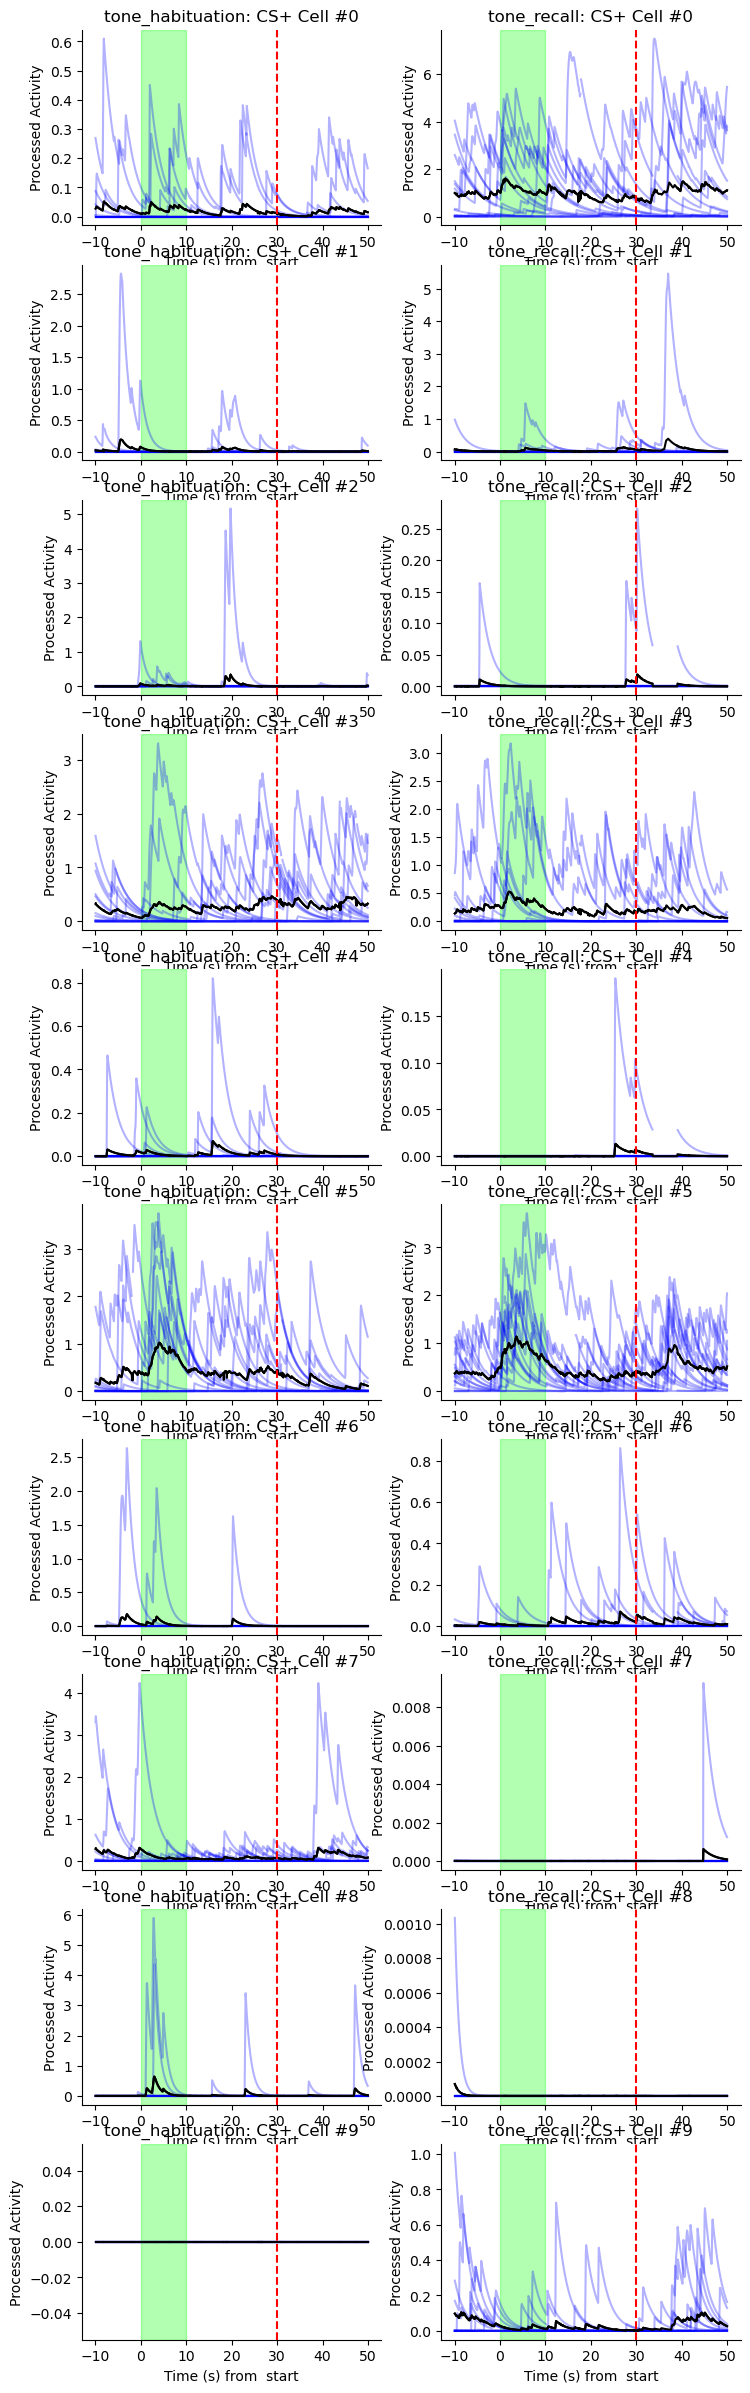

In [89]:
plot_paired_CS_PETH(careg.caneurons, event_starts=[events[0][0], events[1][0]], 
                    event_ends=[events[0][1], events[1][1]], var_plot='C', 
                    neuron_inds=[coactive_map.iloc[:, 0], coactive_map.iloc[:, 1]], 
                    cs_types=cs_types, sesh_names=session_types, cs_color=[[0, 1, 0, 0.3]]*2)

## Tone Recall CS+ 

In [ ]:
plot_CS_PETH(sesh_dir, caneurons, 'tone_recall', 'CS+')

## Control Tone Recall CS-

In [ ]:
# Load in event data
plot_CS_PETH(sesh_dir, caneurons, 'control_tone_recall', 'CS-')

## Control Tone Recall CS+

In [ ]:
# Load in event data
plot_CS_PETH(sesh_dir, caneurons, 'control_tone_recall', 'CS+')

## NRK todo:  

~~1) automate loading in events file - concatenate if there are multiple, should be easy to filter out and ignore post-hoc with pandas indexing  ~~
  
~~2) Filter out bad neurons - use "curated_neurons.pkl" file to grab only good ones~~

~~3) Debug RunTimeWarning above~~

4) turn plotting function a function on its own? Maybe keep in notebook for now and just run three separate cells? Yes.

5) Plot each neuron's activity side-by-side across all three conditions.

6) Plot across days - during training, during shock, and during recall1.

7) Fold code bits above into trace_fc class for easier access!!!
